# Science articles classifier

In [1]:
import pandas as pd
from collections import Counter
import numpy as np
import re
from tqdm import tqdm
tqdm.pandas()

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords
import string
import pickle as pk

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

C:\ProgramData\Anaconda3\lib\site-packages\tqdm\std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [2]:
train_raw = pd.read_csv('train.csv')

In [3]:
train_raw['tags']=''

for col_name in train_raw.drop(['ID','TITLE','ABSTRACT'],axis=1).columns:
    train_raw.loc[train_raw[col_name]==1,'tags'] = train_raw['tags']+' | '+col_name
    
train_raw['tags'] = train_raw['tags'].apply(lambda x: x[2:])

In [4]:
encode = train_raw.groupby('tags').count().sort_values('ID',ascending=False).reset_index()
encode = encode[encode['ID']>=50].reset_index()
encode = encode[['tags','index']].rename(columns={'index':'target'})
encode.head()

,tags,target
0,Physics,0
1,Computer Science,1
2,Mathematics,2
3,Computer Science | Statistics,3
4,Statistics,4


In [5]:
encode.to_csv('class_def.csv',index=False)

In [6]:
train = train_raw.merge(encode, on=['tags'], how='left').dropna()

In [7]:
train['text'] = train.apply(lambda x: '{} {}'.format(x.TITLE,x.ABSTRACT),axis=1)
train = train[['text','target']]

In [8]:
train.head()

,text,target
0,Reconstructing Subject-Specific Effect Maps ...,1.0
1,Rotation Invariance Neural Network Rotation ...,1.0
2,Spherical polyharmonics and Poisson kernels fo...,2.0
3,A finite element approximation for the stochas...,2.0
4,Comparative study of Discrete Wavelet Transfor...,3.0


In [9]:
# Check size of each category
train.groupby('target').size()

target
0.0     5120
1.0     4910
2.0     3610
3.0     2285
4.0     1636
5.0      825
6.0      682
7.0      443
8.0      437
9.0      293
10.0     209
11.0     179
12.0     105
13.0      99
dtype: int64

In [10]:
train.shape

(20833, 2)

In [11]:
# Load english stopwords
import nltk
nltk.download('stopwords')
print(stopwords.words('english'))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\laure\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [12]:
# Parsing text + cleaning + stemm
def parse_out_text(all_text):
    all_text = re.sub('\s+',' ',all_text).replace('\n','')
    # clean punctuation, make lower case and remove stopwords
    text_string = all_text.translate(str.maketrans("", "", string.punctuation)).split(" ")
    text_string = [word.lower() for word in text_string if word.lower() not in stopwords.words('english')]
    # Stemm text
    stemmer = SnowballStemmer("english")
    stemmed = [stemmer.stem(word) for  word in text_string]
    words = " ".join(stemmed) 
    return words

In [13]:
# Text example
text_test = train['text'].iloc[42]
text_test

'Probing valley filtering effect by Andreev reflection in zigzag graphene nanoribbon   Ballistic point contact (BPC) with zigzag edges in graphene is a main\ncandidate of a valley filter, in which the polarization of the valley degree of\nfreedom can be selected by using a local gate voltage. Here, we propose to\ndetect the valley filtering effect by Andreev reflection. Because electrons in\nthe lowest conduction band and the highest valence band of the BPC possess\nopposite chirality, the inter-band Andreev reflection is strongly suppressed,\nafter multiple scattering and interference. We draw this conclusion by both the\nscattering matrix analysis and the numerical simulation. The Andreev reflection\nas a function of the incident energy of electrons and the local gate voltage at\nthe BPC is obtained, by which the parameter region for a perfect valley filter\nand the direction of valley polarization can be determined. The Andreev\nreflection exhibits an oscillatory decay with the leng

In [14]:
# Parsed text example
parse_out_text(text_test)

'probe valley filter effect andreev reflect zigzag graphen nanoribbon ballist point contact bpc zigzag edg graphen main candid valley filter polar valley degre freedom select use local gate voltag propos detect valley filter effect andreev reflect electron lowest conduct band highest valenc band bpc possess opposit chiral interband andreev reflect strong suppress multipl scatter interfer draw conclus scatter matrix analysi numer simul andreev reflect function incid energi electron local gate voltag bpc obtain paramet region perfect valley filter direct valley polar determin andreev reflect exhibit oscillatori decay length bpc indic negat correl valley polar '

In [15]:
%%time
parsed_train = pd.DataFrame(train['text'].progress_apply(parse_out_text))
parsed_train['target'] = train['target']

100%|████████████████████████████████████████████████████████████████████████████| 20833/20833 [19:18<00:00, 17.98it/s]

Wall time: 19min 18s


In [16]:
print(parsed_train.isna().sum())

text      0
target    0
dtype: int64


In [17]:
# Loop over all the words in all the texts and increment the counts in the appropriate counter objects
def count_most_common(cat,number):
    count_word = Counter()
    df_cat = parsed_train[parsed_train['target'] == cat]
    for article in df_cat['text']:
        for word in article.split(" "):
            count_word[word] += 1
    return count_word.most_common(number)

In [18]:
count_most_common(0,10)

[('', 7190),
 ('use', 3963),
 ('model', 3937),
 ('system', 2840),
 ('observ', 2586),
 ('result', 2433),
 ('field', 2411),
 ('effect', 2343),
 ('magnet', 2267),
 ('studi', 2234)]

In [19]:
count_most_common(1,10)

[('', 5975),
 ('use', 5649),
 ('model', 4477),
 ('network', 4170),
 ('system', 3685),
 ('propos', 3433),
 ('algorithm', 3341),
 ('data', 3261),
 ('method', 3095),
 ('problem', 3083)]

In [20]:
parsed_train_text = np.array(parsed_train['text'])

In [22]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Implement vectorizer
vectorizer = TfidfVectorizer(max_features=10000)

# Fit transform train data
X_train_vector = vectorizer.fit_transform(parsed_train_text)
X_train_vector = X_train_vector.toarray()

# display some words from the vectorizer
words = vectorizer.get_feature_names()
print(words[1500:1510])

# dump vectorizer in a pickle file
with open("vectorizer.pkl", 'wb') as file:
    pk.dump(vectorizer, file)

In [23]:
# extract targets from train data
y_train_target = np.array(parsed_train['target'])

In [24]:
print('X_train_vector shape:',X_train_vector.shape)
print('y_train_target shape:',y_train_target.shape)

X_train_vector shape: (20833, 10000)
y_train_target shape: (20833,)


In [25]:
# create train test sets
X_train, X_test, y_train, y_test = train_test_split(
    X_train_vector, 
    y_train_target, 
    stratify=y_train_target, 
    test_size=0.15, 
    random_state=42
)

In [26]:
print('X_train shape:',X_train.shape)
print('y_train shape:',y_train.shape)
print('X_test shape:',X_test.shape)
print('y_test shape:',y_test.shape)

X_train shape: (17708, 10000)
y_train shape: (17708,)
X_test shape: (3125, 10000)
y_test shape: (3125,)


In [38]:
# cross-validator : ShuffleSplit 
sss = StratifiedShuffleSplit(n_splits = 5, test_size = 0.2, random_state = 42) # To avoid over-fitting

### Import classifier ###
from sklearn.svm import LinearSVC
clf = LinearSVC()

# definition of the pipeline
pipeline = Pipeline(steps = [
    ("LSVC",clf)
])

# parameters to tune 
param_grid = {
    'LSVC__C' : [1],
    'LSVC__class_weight' : ['balanced'],
    'LSVC__multi_class' : ['ovr'],
    'LSVC__random_state' : [42],
    'LSVC__max_iter' : [10000],
}  

# exhaustive search over specified parameter
grid = GridSearchCV(pipeline, param_grid, verbose = 1, cv = sss)

In [39]:
%%time
# training classifier
print (" > training classifier:")
grid.fit(X_train, y_train.ravel())

# best classifier using the cross-validator and the Stratified Shuffle Split 
clf = grid.best_estimator_

# print grid parameters
print ("\n > Best grid search:")
print (grid.best_params_)

# Evaluation metrics
print(classification_report(y_test, clf.predict(X_test)))

 > training classifier:
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   51.5s finished



 > Best grid search:
{'LSVC__C': 1, 'LSVC__class_weight': 'balanced', 'LSVC__max_iter': 10000, 'LSVC__multi_class': 'ovr', 'LSVC__random_state': 42}
              precision    recall  f1-score   support

         0.0       0.91      0.89      0.90       768
         1.0       0.72      0.67      0.70       737
         2.0       0.81      0.85      0.83       541
         3.0       0.45      0.49      0.47       343
         4.0       0.29      0.24      0.26       245
         5.0       0.56      0.56      0.56       124
         6.0       0.23      0.25      0.24       102
         7.0       0.43      0.56      0.48        66
         8.0       0.24      0.32      0.28        66
         9.0       0.17      0.18      0.18        44
        10.0       0.70      0.84      0.76        31
        11.0       0.26      0.33      0.29        27
        12.0       0.17      0.12      0.14        16
        13.0       0.33      0.13      0.19        15

    accuracy                          

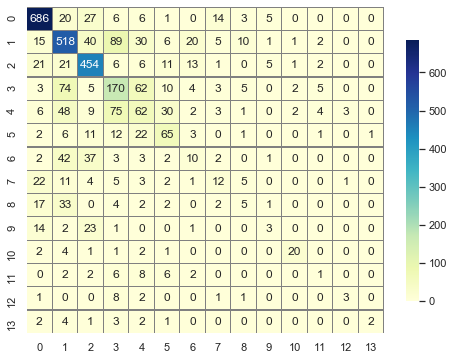

In [40]:
y_test_pred = cross_val_predict(clf, X_test, y_test, cv=3)

fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(
    confusion_matrix(y_test, y_test_pred), 
    cmap='YlGnBu', 
    linewidths=.2,
    linecolor='gray',
    cbar_kws={"shrink": .8},
    annot = True,
    fmt='d'
)

In [41]:
# dump classifier in a pickle file
with open("clf.pkl", 'wb') as file:
    pk.dump(clf, file)

### Valid corpus

In [42]:
# Load categories
with open("clf.pkl", 'rb') as fid:
    trained_clf = pk.load(fid)

In [43]:
# Load categories
with open("vectorizer.pkl", 'rb') as fid:
    fitted_vect = pk.load(fid)

In [44]:
encode = pd.read_csv('class_def.csv')

In [45]:
def parse_out_text(all_text):
    all_text = re.sub('\s+',' ',all_text).replace('\n','')
    # clean punctuation, make lower case and remove stopwords
    text_string = all_text.translate(str.maketrans("", "", string.punctuation)).split(" ")
    text_string = [word.lower() for word in text_string if word.lower() not in stopwords.words('english')]
    # Stemm text
    stemmer = SnowballStemmer("english")
    stemmed = [stemmer.stem(word) for  word in text_string]
    words = " ".join(stemmed) 
    return words

In [74]:
def make_pred(title, abstract):
    text = title + ' '+abstract
    print(title+'\n')
    print(abstract)
    
    parsed_text = parse_out_text(text)
    X_vector = vectorizer.transform([parsed_text]).toarray()
    
    categ = encode[encode.target == trained_clf.predict(X_vector)[0]]['tags'].iloc[0]
    print('\nPredicted category:'+categ)
    
    df_vect = pd.DataFrame({
        'weight':X_vector[0],
        'words':vectorizer.get_feature_names()
    })
    display(df_vect[df_vect.weight != 0].sort_values('weight',ascending=False).head(10).reset_index(drop=True))

In [75]:
valid = pd.read_csv('test.csv')
valid.head()

,ID,TITLE,ABSTRACT
0,20973,Closed-form Marginal Likelihood in Gamma-Poiss...,We present novel understandings of the Gamma...
1,20974,Laboratory mid-IR spectra of equilibrated and ...,Meteorites contain minerals from Solar Syste...
2,20975,Case For Static AMSDU Aggregation in WLANs,Frame aggregation is a mechanism by which mu...
3,20976,The $Gaia$-ESO Survey: the inner disk intermed...,Milky Way open clusters are very diverse in ...
4,20977,Witness-Functions versus Interpretation-Functi...,Proving that a cryptographic protocol is cor...


In [76]:
spl = valid.sample(1)
title = spl.TITLE.iloc[0]
abstract = spl.ABSTRACT.iloc[0]

make_pred(title, abstract)

The pragmatics of clone detection and elimination

  The occurrence of similar code, or `code clones', can make program code
difficult to read, modify and maintain. This paper describes industrial case
studies of clone detection and elimination using a refactoring and clone
detection tool. We discuss how the studies have informed the design of the
tool; more importantly, we use the studies to illustrate the complex set of
decisions that have to be taken when performing clone elimination in practice.
The case studies were performed in collaboration with engineers from Ericsson
AB, and used the refactoring tool Wrangler for Erlang. However, the conclusions
we draw are largely language-independent, and set out the pragmatics of clone
detection and elimination in real-world projects as well as design principles
for clone detection decision-support tools.


Predicted category: Computer Science


,weight,words
0,0.742410,clone
1,0.294961,elimin
2,0.229137,detect
3,0.227052,refactor
4,0.213792,pragmat
5,0.206926,tool
6,0.166052,code
7,0.119504,studi
8,0.086133,design
9,0.081518,ab
